28.11.2023 Meeting

Overview:

[x] Visualize predicted vs true values (scatterplot with seaborn) of model predicting click difference from difference embedding (true difference - predicted difference)

[x] show headlines that scored highly and compare with headlines scored low 

[ ] compare ranking between model using embeddings and embedding difference to predict clicks / click difference

[x] make list of potential explanations of what the model is capturing (speech text / punctuation)

[x] introducing click rate

 

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math

In [3]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [4]:
#Define model - pretrained
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')


In [5]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#Delete some unnecessary columns
print(df.columns)
delete_cols = ["created_at","updated_at","share_text","square"]
df = df.drop(columns=delete_cols)
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]),ndigits=3)
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 4.64 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 2.11 packages with the same eyecatcher id and same clickability_test_id
clicks =torch.tensor(df.clicks.values)

Index(['Unnamed: 0', 'created_at', 'updated_at', 'clickability_test_id',
       'excerpt', 'headline', 'lede', 'slug', 'eyecatcher_id', 'impressions',
       'clicks', 'significance', 'first_place', 'winner', 'share_text',
       'square', 'test_week'],
      dtype='object')
Unnamed: 0       4.641032
excerpt          4.147870
headline         4.641032
lede             4.638130
slug             4.641032
eyecatcher_id    4.635272
impressions      4.641032
clicks           4.641032
significance     4.641032
first_place      4.641032
winner           4.641032
test_week        4.641032
clickrate        4.641032
dtype: float64
Unnamed: 0      2.117931
excerpt         1.892597
headline        2.117931
lede            2.116605
slug            2.117931
impressions     2.117931
clicks          2.117931
significance    2.117931
first_place     2.117931
winner          2.117931
test_week       2.117931
clickrate       2.117931
dtype: float64


In [6]:
#Load embeddings
with open('all-mpnet-base-v2_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']



# 1. Predicting clicks from headline embeddings with ridge regression (incl. comparison with linear)

In [7]:
# Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)

In [8]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train) #0.1629
predictions = ridge_model.predict(X_test) #alpha = 10
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions"] = ridge_model.predict(stored_embeddings)
print("Spearman correlation:",spearmanr(df.sort_values(["predictions"]).loc[:,"headline"],df.sort_values(["clicks"]).loc[:,"headline"]))



Ridge Regression MSE for click difference: 1547.9106750314263
Ridge Regression R2 for click difference: 0.2229719967601247
Spearman correlation: SignificanceResult(statistic=-0.00029870112721966976, pvalue=0.922692478942039)


### Last 20

In [9]:
from ipywidgets import widgets, Layout
from IPython import display

last20_pred = df.sort_values(["predictions"],ascending=True).loc[:,['headline']][:20]
last20_true = df.sort_values(["clicks"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [10]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

#### Potential explanations: PREDICTED
1. Capital letters
2. Punctuation - exlamation marks, question marks
3. Future
4. Focus on the reader
 

#### Potential explanations: TRUE
1. Capital letters
2. Focus on the reader - imagine if, what would happen if you

## Top 20

In [11]:
top20_pred = df.sort_values(["predictions"],ascending=False).loc[:,['headline']][:20]
top20_true = df.sort_values(["clicks"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box


In [11]:
#Checking for intersection
np.intersect1d(top20_pred.values,top20_true.values)

array(['Lorde Found A Photoshopped Photo Of Herself And Decided To Tweet The Untouched Real One Next To It'],
      dtype=object)

#### Potential explanations:
1. Call to action words - "Watch", "See"
2. Capital letters
3. Famous names

## Linear Model

In [12]:
# Linear Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clicks, test_size=0.2)
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))

Linear Regression MSE for clicks: 39.94353473018317
Linear Regression R2 for clicks: 0.22825407230808903


### Visualizing predicted clicks vs actual clicks

159.10695304595822


(-100.0, 800.0)

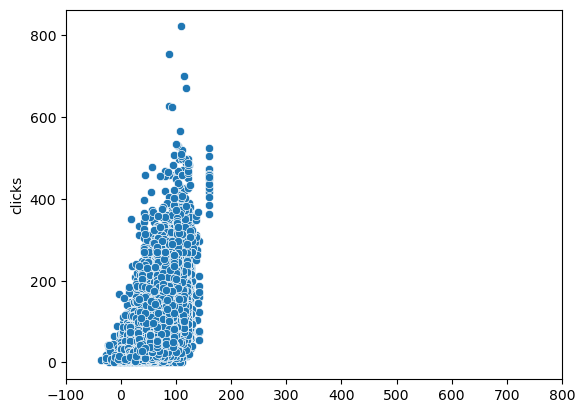

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)


C:\Users\mldem\AppData\Local\Temp\ipykernel_24528\131465719.py:1: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  plot = sns.jointplot(x = predictions, y = df['clicks'], kind="hex", color="#B391", ax=ax)
C:\Users\mldem\anaconda3\envs\causalclicker\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mldem\anaconda3\envs\causalclicker\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 800.0)

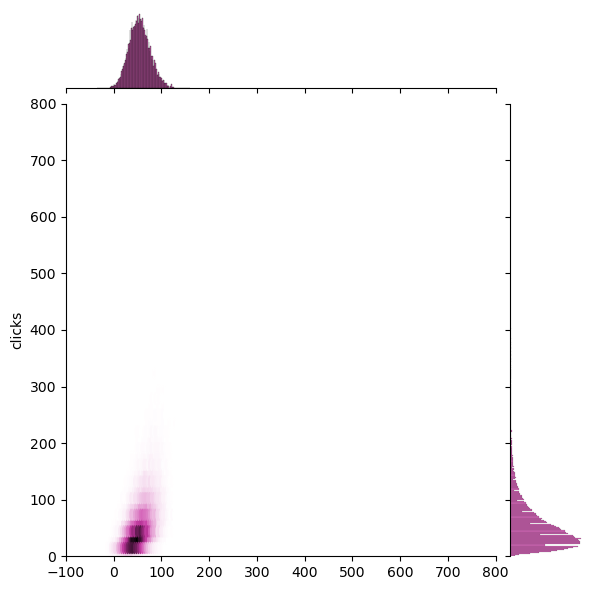

In [15]:
plot = sns.jointplot(x = predictions, y = df['clicks'], kind="hex", color="#B391", ax=ax)
plot.ax_marg_x.set_xlim(-100, 800)
plot.ax_marg_y.set_ylim(0, 800)

## Extra:MLP Regressor model 

In [15]:
from sklearn.neural_network import MLPRegressor
MLP_regressor = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
predictions_mlp = MLP_regressor.predict(X_test)
r2_score(y_true=y_test,y_pred=predictions_mlp)


/Users/tonia/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.585169974436185

(-100.0, 800.0)

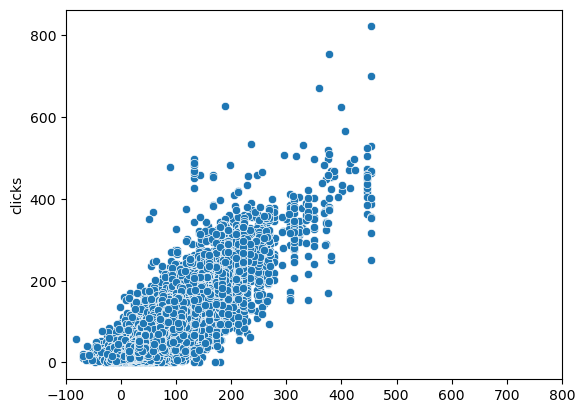

In [16]:
predictions_all = MLP_regressor.predict(stored_embeddings)

# visualize real and predicted values
fig, ax = plt.subplots()
sns.scatterplot(x = predictions_all, y = df['clicks'], ax=ax)
ax.set_xlim(-100,800)

/var/folders/1p/knjx3tp94tzgck8pfkr9w8t00000gn/T/ipykernel_68660/3254701675.py:2: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  plot = sns.jointplot(x = predictions, y = df['clicks'], kind="hex", color="#B391", ax=ax)
/Users/tonia/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tonia/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 800.0)

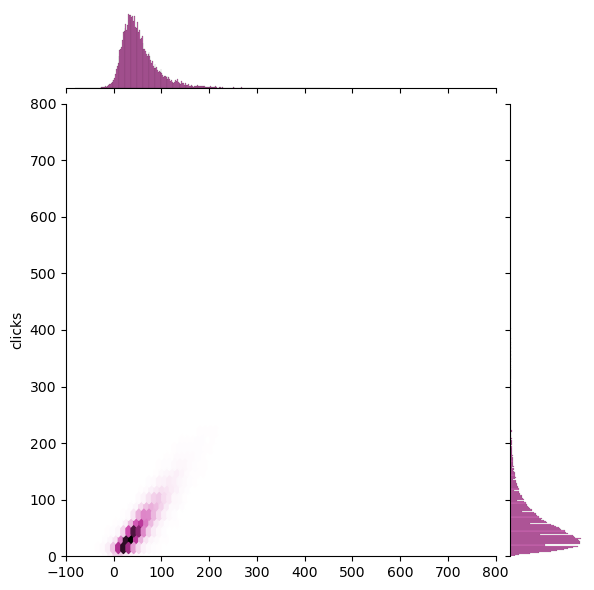

In [17]:
predictions = MLP_regressor.predict(stored_embeddings)
plot = sns.jointplot(x = predictions, y = df['clicks'], kind="hex", color="#B391", ax=ax)
plot.ax_marg_x.set_xlim(-100, 800)
plot.ax_marg_y.set_ylim(0, 800)

In [16]:
#Pair headlines based on clickability_test_id and eyecatcher_id
#Import dataset with pairs
df_pairs = pd.read_csv("headline_pair_indices.csv")
#Compute vector difference
embedding_diff = torch.stack(df_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 
#because we have a column where each row is a tensor so we kinda unpack them.
#Sort pairs s.t. headline1 is headline with more clicks. 
df_sorted_pairs = df_pairs.copy()
df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline1', 'Idx_Headline2']] = df_sorted_pairs.loc[~df_sorted_pairs["headline1_more_clicks"], ['Idx_Headline2', 'Idx_Headline1']].values
df_sorted_pairs['click_difference'] = abs(df_pairs['click_difference'])

### Ridge with clickrate instead of clicks

In [17]:
clickrate =torch.tensor(df.clickrate.values)

X_train, X_test, y_train, y_test = train_test_split(stored_embeddings,clickrate, test_size=0.2)
# Ridge Model

ridge_model_clickrate =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model_clickrate.fit(X_train, y_train)
ridge_model_clickrate.score(X_train,y_train) #0.1629
predictions_clickrate = ridge_model_clickrate.predict(X_test) #alpha = 10
rmse_clickrate = mean_squared_error(y_test, predictions_clickrate)

predictions_clickrate_all = ridge_model_clickrate.predict(stored_embeddings)
print(predictions_clickrate_all.shape[0])


for i in range(predictions_clickrate_all.shape[0]):
    if predictions_clickrate_all[i] < 0:
        predictions_clickrate_all[i] = 0
        
df["predictions_clickrate_all"] = predictions_clickrate_all

print("Ridge Regression MSE for click rate:", rmse_clickrate)
print("Ridge Regression R2 for click rate:", r2_score(y_true=y_test, y_pred=predictions_clickrate))


105551
Ridge Regression MSE for click rate: 0.00011724581098361382
Ridge Regression R2 for click rate: 0.23680252213714825


### Last 20 clickrate

In [18]:
last20_pred = df.sort_values(["predictions_clickrate_all"],ascending=True).loc[:,['headline']][:20]
last20_true = df.sort_values(["clickrate"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box


In [21]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

#### Potential explanations:
1. Questions
2. Topics about the future - i.e food shortage, water supply, preparing for tornadoes

### Top 20 clickrate


In [19]:
top20_pred = df.sort_values(["predictions_clickrate_all"],ascending=False).loc[:,['headline']][:20]
top20_true = df.sort_values(["clickrate"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [23]:
#Checking for intersection
np.intersect1d(top20_pred.values,top20_true.values)

array(['Lorde Found A Photoshopped Photo Of Herself And Decided To Tweet The Untouched Real One Next To It'],
      dtype=object)

#### Potential explanations:
1. Capital letters
2. Famous names

# 2 Predicting Headline-Winner based on SBert Embeddings with Logistic Regression

In [24]:
headline1_more_clicks = torch.tensor(df_pairs['headline1_more_clicks'])
X_train, X_test, y_train, y_test = train_test_split(embedding_diff, headline1_more_clicks, test_size=0.2)
logistic = LogisticRegression(max_iter=200)
logistic.fit(X_train, y_train)
predicted_logistic = logistic.predict(X_test)
accuracy_logistic = accuracy_score(predicted_logistic,y_test)
print("Accuracy predicting winner:", accuracy_logistic)

Accuracy predicting winner: 0.6436420722135008


# 3 Predicting Click difference based on SBert embeddings with Ridge Regression

In [20]:
#check shape matching and turning into tensors to work
clicks_diff = torch.tensor(df_sorted_pairs['click_difference'])

#take sorted embeddings 
sorted_embedding_diff = torch.stack(df_sorted_pairs.apply(lambda row: stored_embeddings[row['Idx_Headline1']] - stored_embeddings[row['Idx_Headline2']], axis=1).tolist()) 

In [21]:
#Based on difference vector
X_train, X_test, y_train, y_test = train_test_split(sorted_embedding_diff, clicks_diff, test_size=0.2, random_state=seed)
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.09528
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
df_sorted_pairs["predictions"] = ridge_model_diff.predict(sorted_embedding_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 

Ridge Regression MSE for clicks difference: 246.38947017659206
Ridge Regression R2 for click difference: 0.05341839571557916


### Last 20 winners with the smallest click difference

In [22]:
last20_pred = df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=True).loc[:,'Idx_Headline1'][:20], ['headline']]
last20_true =df.loc[df_sorted_pairs.sort_values(["click_difference"], ascending=True).loc[:,'Idx_Headline1'][:20], ['headline']]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box




In [23]:
## checking for intersection
# looking at top 200 we get 3 overlaps.
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)

In [29]:
#### Possible explanations:
1.
2.

2.0

### Top 20 - winners with highest click difference


In [24]:
top20_pred = df.loc[df_sorted_pairs.sort_values(["predictions"], ascending=False).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]
top20_true = df.loc[df_sorted_pairs.sort_values(["click_difference"], ascending=False).loc[:,'Idx_Headline1'][:20], ['headline', 'clicks']]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(top20_pred.style.set_caption('Top 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(top20_true.style.set_caption('Top 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box



#### Posible explanations:
1. Beginning of a story - i.e a man screamed, an interviewer asks..
2. Capital letters
3. Famous names

(-20.0, 400.0)

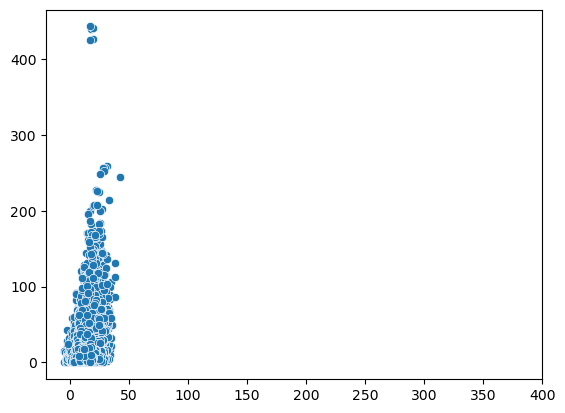

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# visualize real and predicted values
pred = ridge_fit_diff.predict(sorted_embedding_diff)
fig, ax = plt.subplots()
sns.scatterplot(x = pred, y = clicks_diff, ax=ax)
ax.set_xlim(-20,400)
## this is super sketchy. 

/var/folders/1p/knjx3tp94tzgck8pfkr9w8t00000gn/T/ipykernel_68660/399871113.py:1: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  plot = sns.jointplot(x = pred, y = clicks_diff, kind="hex", color="#B391", ax=ax)
/Users/tonia/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tonia/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 100.0)

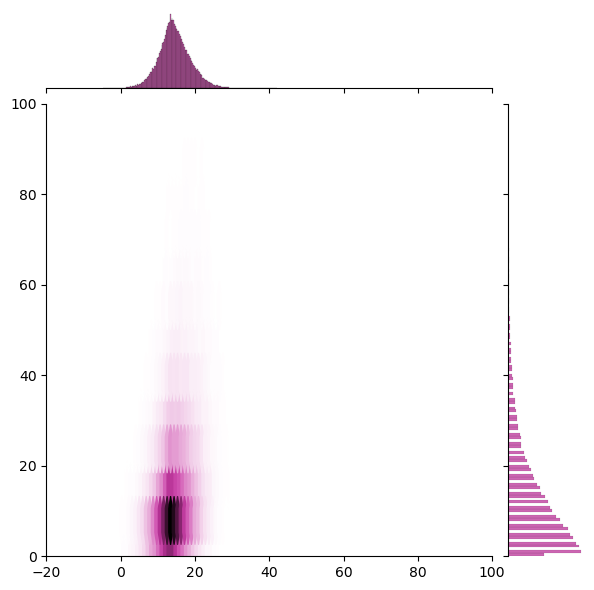

In [32]:
plot = sns.jointplot(x = pred, y = clicks_diff, kind="hex", color="#B391", ax=ax)
plot.ax_marg_x.set_xlim(-20, 100)
plot.ax_marg_y.set_ylim(0, 100)

In [33]:
(df_sorted_pairs['click_difference']>100).sum()

320

In [34]:
(df_sorted_pairs['predictions']>100).sum()

0

### Compare headline ranking between true click difference and predicted click difference

In [35]:
predicted_ranking = df_sorted_pairs.sort_values(['predictions'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['predictions'])['Idx_Headline2'].astype(str).values
true_ranking = df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline1'].astype(str).values+df_sorted_pairs.sort_values(['click_difference'])['Idx_Headline2'].astype(str).values

print("Spearman correlation is",spearmanr(predicted_ranking, true_ranking))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation is SignificanceResult(statistic=-0.002244437247046531, pvalue=0.4806664028168418)


# Extra: Prediction based on concatenated full embeddings

In [36]:
## Here we need to make sure the headline ordering is correct so we use sorted pairs 
#Compute concatenated embeddings of the pairs
vec1 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline1']]), axis=1)
vec1= torch.stack(vec1.tolist())
vec2 = df_sorted_pairs.apply(lambda row:(stored_embeddings[row['Idx_Headline2']]), axis=1)
vec2= torch.stack(vec2.tolist())
concatenated_vector = torch.cat([vec1, vec2], dim=1)
print(concatenated_vector)

tensor([[-0.0192,  0.0033, -0.0165,  ...,  0.0509,  0.0051,  0.0119],
        [-0.0515,  0.0327, -0.0301,  ..., -0.0070, -0.0049,  0.0196],
        [-0.0515,  0.0327, -0.0301,  ...,  0.0189,  0.0471, -0.0174],
        ...,
        [ 0.0210,  0.0616, -0.0244,  ..., -0.0313,  0.0379,  0.0164],
        [ 0.0325,  0.0813, -0.0349,  ..., -0.0531, -0.0203,  0.0014],
        [ 0.0210,  0.0616, -0.0244,  ..., -0.0531, -0.0203,  0.0014]])


In [37]:
#Based on concatenated full embeddings
X_train, X_test, y_train, y_test = train_test_split(concatenated_vector, clicks_diff, test_size=0.2)

In [38]:
# Ridge Model
ridge_model_diff =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_fit_diff = ridge_model_diff.fit(X_train, y_train)
ridge_fit_diff.score(X_train,y_train) #0.01513
ridge_predictions_diff = ridge_model_diff.predict(X_test)
ridge_rmse_diff = mean_squared_error(y_test, ridge_predictions_diff)
print("Ridge Regression MSE for clicks difference:", ridge_rmse_diff)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=ridge_predictions_diff)) 


Ridge Regression MSE for clicks difference: 232.31809109871168
Ridge Regression R2 for click difference: 0.1092000171840255


In [39]:
# Linear Model
lin_model_diff = LinearRegression()
lin_fit_diff = lin_model_diff.fit(X_train, y_train)
lin_fit_diff.score(X_train,y_train)
lin_predictions_diff = lin_model_diff.predict(X_test)
lin_rmse_diff = mean_squared_error(y_test, lin_predictions_diff)
print("Linear Regression MSE for clicks difference:", lin_rmse_diff) #Result is better with linear regression
print("Linear Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=lin_predictions_diff)) 

Linear Regression MSE for clicks difference: 233.20560222270268
Linear Regression R2 for click difference: 0.10579694646206339
